 ## EELT 7023 - Tópicos Especiais em Identificação de Sistemas

#### Aluno:

### $$\textbf{Exercício 6}$$

$\textbf{Objetivo:}$ Utilizar o conjunto de dados de $\omega_k$ e $G(j\omega_k)$ do exercício 5 para estimar modelos utilizando o método de Sanathanan-Koerner (SK). A intenção é avaliar as respostas do método considerando um sistema com ruído gaussiano na entrada.

Deseja-se, além disso, avaliar a função custo a cada iteração, de modo a ser possível avaliar a evolução do médodo conforme a passagem das iterações.

Apenas para recordar, a função de transferência $G(s)$ é dada por

$$G(s) = \frac{2s}{1+2s+6s^2}$$

onde $s$ é a frequência complexa da transformada de Laplace e pode ser substituída por $j\omega$.

### DADOS DO SISTEMA REAL

In [1]:
# Função para gerar pontos espaçados logaritmicamente
LogSpace(start, stop, steps) = [10^i for i in range(log10(start), log10(stop), length=steps)]

# Parâmetros da simulação
total_points = 1000
# Limites de frequência
ω_start, ω_stop = 0.01, 10
# Coeficientes do numerador e do denominador
num = [0, 2]
den = [1, 2, 6]

# Vetor de frequência
ω =LogSpace(ω_start, ω_stop, total_points)

function gera_dados(num, den, ω, total_points, noise)
    numerador = zeros(total_points)

    # A notação de Julia para valores imaginários é "im" no lugar do tradicional "j"
    for n=1:length(num)
        numerador = numerador .+ (ω * 1im).^(n - 1) * num[n];
    end

    denominador = zeros(total_points);
    for d=1:length(den)
        denominador = denominador .+ (ω * 1im).^(d - 1) * den[d];
    end

    G = numerador ./ denominador;
    return G + noise * (rand(total_points) + 1im * rand(total_points));
end

G = gera_dados(num, den, ω, total_points, 0.005);

Os gráficos a seguir apresentam o ângulo e o módulo do sistema ser identificado, já com o ruído gaussiano inserido.

In [2]:
G_mag = abs.(G);
G_phase = angle.(G) * 180 / pi;

In [3]:
# Biblioteca necessária para plotar gráficos
using Plots
pyplot()

Plots.PyPlotBackend()

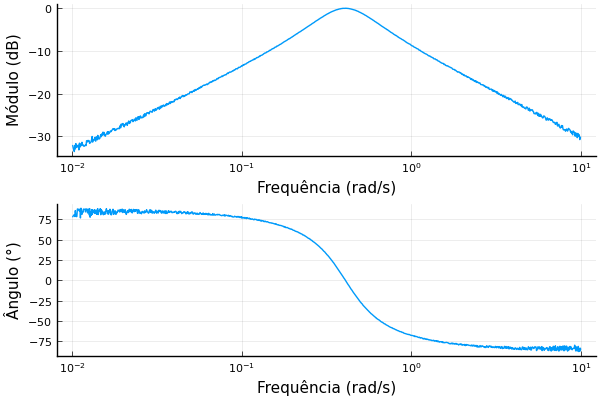

In [4]:
plot_mag = plot(ω, 20*log10.(G_mag), xlabel="Frequência (rad/s)", yaxis="Módulo (dB)", xaxis=:log)
plot_pha = plot(ω, G_phase, xlabel="Frequência (rad/s)", yaxis="Ângulo (°)", xaxis=:log)

plot(plot_mag, plot_pha, layout=(2,1), legend=false)

## ALGORITMO DE SANATHANAN-KOERNER (SK)

In [5]:
# Biblioteca necessária para criar matrizes diagonal
using LinearAlgebra

function modelo_sk(na, nb, G, ω, iter_max)
    # Inicializar vetor A_linha
    A_linha = ones(length(G))
    
    # É necessário inicializar o θ aqui para que ele possa ser
    # utilizado também fora do loop. O mesmo ocorre com o modelo
    θ = nothing
    G_modelo = nothing
    
    for iter = 1:iter_max
        # Criação da matriz W
        W = Diagonal(1 ./ A_linha)
        
        # Criação da matriz M
        M = Array{Complex{Float64}, 2}(undef, length(G), na + nb + 1)
        M[:, 1] .= 1

        # Coeficientes relacionados ao numerador
        for i=1:nb
            m_i = i + 1
            M[:, m_i] = (ω * 1im) .^ i
        end

        # Coeficientes relacionados ao denominador
        for i=1:na
            m_i = i + nb + 1
            M[:, m_i] = -1 * G .* (ω * 1im) .^ i
        end
        
        M = W * M
        y = W * G
        
        # Matrizes adaptadas
        M_til = [real(M); imag(M)]
        y_til = [real(y); imag(y)]

        # Cálculo de theta
        θ = M_til \ y_til

        b_array = θ[1:nb+1]
        a_array = θ[nb+2:nb+na+1]

        # Numerador do modelo obtido
        num_til = zeros(length(G))

        for n=1:length(b_array)
            num_til = num_til + (ω * 1im).^(n - 1) * b_array[n];
        end

        # Denominador do modelo obtido
        den_til = ones(length(G));
        for d=1:length(a_array)
            den_til = den_til + (ω * 1im) .^ d * a_array[d];
        end

        G_modelo = num_til ./ den_til;
        A_linha = den_til[:]
    
    end
    
    return θ, G_modelo
end

modelo_sk (generic function with 1 method)

O algoritmo SK padrão foi implementado acima. Afim de avaliar a evolução das primeiras cinco iterações, serão apresentados os resultados para $\theta$ e para o modelo após cada uma.

In [6]:
function plota_modelo(na, nb, iter_max)
    
    θ, modelo = modelo_sk(na, nb, G, ω, iter_max)

    modelo_mag = abs.(modelo)
    modelo_pha = angle.(modelo) * 180 / pi

    J_til = sum(abs.(modelo - G) .^ 2)
    println("Valor de J_til é $J_til")
    println("Valor de θ é $(round.(θ, digits=6))")

    plot_mag = plot(ω, 20*log10.(G_mag), xlabel="Frequência (rad/s)", 
                    yaxis="Módulo (dB)", xaxis=:log, label="Sistema Real")
    plot!(ω, 20*log10.(modelo_mag), label="Modelo", title="Na = $na e Nb = $nb")

    plot_pha = plot(ω, G_phase, xlabel="Frequência (rad/s)", yaxis="Ângulo (°)", 
                    xaxis=:log, label="Sistema Real")
    plot!(ω, modelo_pha, label="Modelo")

    plot(plot_mag, plot_pha, layout=(2,1))
end

plota_modelo (generic function with 1 method)

Valor de J_til é 49.26044563464301
Valor de θ é [0.068171, 0.919819, 1.320888, 2.911622]


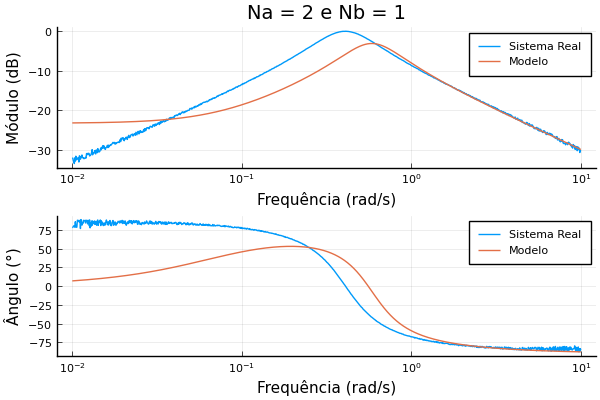

In [7]:
plota_modelo(2, 1, 1)

Valor de J_til é 0.016360043472118745
Valor de θ é [0.000195, 2.002722, 2.007701, 5.995039]


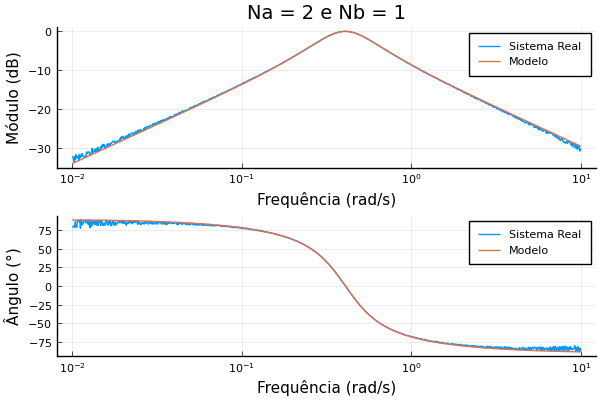

In [8]:
plota_modelo(2, 1, 2)

Valor de J_til é 0.014297047730518824
Valor de θ é [0.001007, 2.008308, 2.005917, 5.993352]

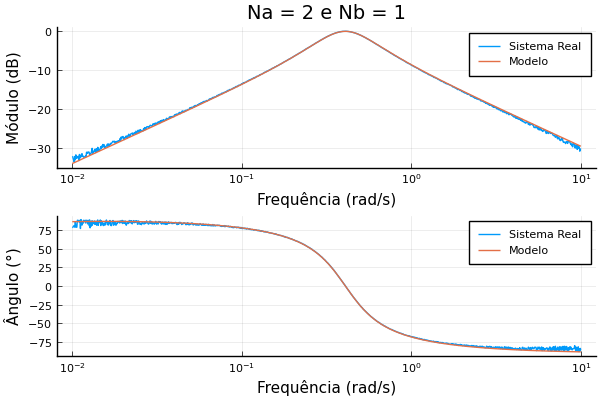

In [9]:
plota_modelo(2, 1, 3)

Valor de J_til é 0.014297061246194138
Valor de θ é [0.001006, 2.008306, 2.005915, 5.993348]


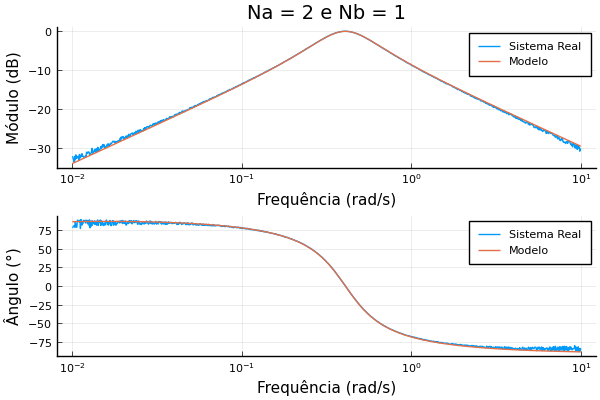

In [10]:
plota_modelo(2, 1, 4)

Valor de J_til é 0.014297061249368494
Valor de θ é [0.001006, 2.008306, 2.005915, 5.993348]


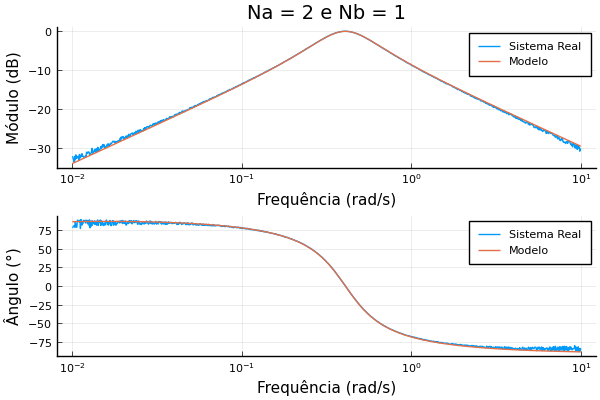

In [11]:
plota_modelo(2, 1, 5)

É possível notar que os modelos a partir da segunda iteração já fornecem valores de $\theta$ bastante próximos dos valores reais. Porém, nem sempre a função objetivo melhorou na iteração seguinte, o que nos leva à necessidade de observar a evolução da função objetivo ao longo das iterações.

Antes disso, porém, deseja-se realizar a estimação dos parâmetros $\theta$ algumas centenas de vezes, de modo a se obter um resultado médio para diversos valores distintos de ruído.

Nessa rodada não levaremos em consideração o critério de convergência. Ao invés disso, faremos o método SK rodar 5 iterações em todos os casos.

In [12]:
# Número de vezes que se deseja rodar o algoritmo
rodadas = 1000
# Nível de ruído gaussiano
noise = 0.005
# Número de iterações
iter_max = 5


# Parâmetros da simulação
total_points = 1000
# Coeficientes do numerador e do denominador
num = [0, 2]
den = [1, 2, 6] # Primeiro coeficiente precisa ser 1
na = length(den) - 1
nb = length(num) - 1

θ = zeros(na + nb + 1)
custo = 0

for i = 1:rodadas
    # Criação dos dados do sistema
    G = gera_dados(num, den, ω, total_points, noise)
    
    # Execução do algoritmo
    θ_i, modelo = modelo_sk(na, nb, G, ω, iter_max)

    J_til = sum(abs.(modelo - G) .^ 2)

    θ = θ + θ_i
    custo += J_til
end

println("O valor médio dos parâmetros θ foi:")
println(round.(θ / rodadas, digits=6))
println("O valor médio da função custo foi de:")
println(custo / rodadas)

O valor médio dos parâmetros θ foi:
[0.000951, 2.008097, 2.005795, 5.993554]
O valor médio da função custo foi de:
0.01459487636494936


Por fim, deseja-se obter o valor da função objetivo após cada iteração. Isso será feito por meio de uma redefinição da função `metodo_sk`.

In [13]:
# Biblioteca necessária para criar matrizes diagonal
using LinearAlgebra

function modelo_sk(na, nb, G, ω, iter_max, record_J)
    # Inicializar vetor A_linha
    A_linha = ones(length(G))
    
    # É necessário inicializar o θ aqui para que ele possa ser
    # utilizado também fora do loop. O mesmo ocorre com o modelo
    θ = nothing
    G_modelo = nothing
    
    # Inicializa o vetor J de acordo com a quantidade de iterações
    if record_J
        J = Array{Float64}(undef, iter_max)
    end
    
    for iter = 1:iter_max
        # Criação da matriz W
        W = Diagonal(1 ./ A_linha)
        
        # Criação da matriz M
        M = Array{Complex{Float64}, 2}(undef, length(G), na + nb + 1)
        M[:, 1] .= 1

        # Coeficientes relacionados ao numerador
        for i=1:nb
            m_i = i + 1
            M[:, m_i] = (ω * 1im) .^ i
        end

        # Coeficientes relacionados ao denominador
        for i=1:na
            m_i = i + nb + 1
            M[:, m_i] = -1 * G .* (ω * 1im) .^ i
        end
        
        M = W * M
        y = W * G
        
        # Matrizes adaptadas
        M_til = [real(M); imag(M)]
        y_til = [real(y); imag(y)]

        # Cálculo de theta
        θ = M_til \ y_til

        b_array = θ[1:nb+1]
        a_array = θ[nb+2:nb+na+1]

        # Numerador do modelo obtido
        num_til = zeros(length(G))

        for n=1:length(b_array)
            num_til = num_til + (ω * 1im).^(n - 1) * b_array[n];
        end

        # Denominador do modelo obtido
        den_til = ones(length(G));
        for d=1:length(a_array)
            den_til = den_til + (ω * 1im) .^ d * a_array[d];
        end
           
        G_modelo = num_til ./ den_til;
        A_linha = den_til[:]
        
        if record_J
            J[iter] = sum(abs.(G_modelo - G) .^ 2)
        end
    
    end
    
    if record_J
        return θ, G_modelo, J
    else
        return θ, G_modelo
    end
end

modelo_sk (generic function with 2 methods)

In [14]:
# Nível de ruído gaussiano
noise = 0.005
# Número de iterações
iter_max = 10

total_points = 1000
# Limites de frequência
ω_start, ω_stop = 0.01, 10
# Coeficientes do numerador e do denominador
num = [0, 2]
den = [1, 2, 6] # Primeiro coeficiente precisa ser 1
na = length(den) - 1
nb = length(num) - 1

G = gera_dados(num, den, ω, total_points, noise)

θ, modelo, J = modelo_sk(na, nb, G, ω, iter_max, true)

# plot(J, ylabel="Função Objetivo", xlabel="Iteração", legend=false)

using Formatting
for i = 1:length(J)
    printfmtln("Iteração {:<3}: {:1.18e}", i, J[i])
end

Iteração 1  : 5.934657745339772672e+01
Iteração 2  : 1.783233301267830784e-02
Iteração 3  : 1.487257988337852736e-02
Iteração 4  : 1.487259372527880448e-02
Iteração 5  : 1.487259372783153536e-02
Iteração 6  : 1.487259372783766400e-02
Iteração 7  : 1.487259372783767104e-02
Iteração 8  : 1.487259372783768640e-02
Iteração 9  : 1.487259372783767936e-02
Iteração 10 : 1.487259372783766400e-02


Como a diferença entre as iterações é muito pequena a partir da segunda iteração, optou-se por apresentar os valores por extenso. Assim, é possível notar que nem sempre um maior número de iterações corresponde a um melhor resultado.

Para concluir as análises referentes a esse método, realizou-se novamente a execução do algoritmo SK 1000 vezes de modo a se obter o valor médio da função custo para as diferentes iterações.

In [15]:
# Número de vezes que se deseja rodar o algoritmo
rodadas = 1000
# Nível de ruído gaussiano
noise = 0.005
# Número de iterações
iter_max = 20


# Parâmetros da simulação
total_points = 1000
# Limites de frequência
ω_start, ω_stop = 0.01, 10
# Coeficientes do numerador e do denominador
num = [0, 2]
den = [1, 2, 6] # Primeiro coeficiente precisa ser 1
na = length(den) - 1
nb = length(num) - 1

θ = zeros(na + nb + 1)
custo = zeros(iter_max)

for i = 1:rodadas
    # Criação dos dados do sistema
    G = gera_dados(num, den, ω, total_points, noise)
    
    # Execução do algoritmo
    θ_i, modelo, J_til = modelo_sk(na, nb, G, ω, iter_max, true)

    θ = θ + θ_i
    custo += J_til
end

println("O valor médio dos parâmetros θ foi:")
println(round.(θ / rodadas, digits=6))

custo = custo / rodadas

# Valor médio da função objetivo após 1000 rodadas do algoritmo
for i = 1:length(custo)
    printfmtln("Iteração {:<3}: {:1.18e}", i, custo[i])
end

O valor médio dos parâmetros θ foi:
[0.000954, 2.0081, 2.005814, 5.993551]
Iteração 1  : 5.216578280099636096e+01
Iteração 2  : 1.691869507506925440e-02
Iteração 3  : 1.459605592088104576e-02
Iteração 4  : 1.459606893381923520e-02
Iteração 5  : 1.459606893662709824e-02
Iteração 6  : 1.459606893663204736e-02
Iteração 7  : 1.459606893663205184e-02
Iteração 8  : 1.459606893663205376e-02
Iteração 9  : 1.459606893663205184e-02
Iteração 10 : 1.459606893663205184e-02
Iteração 11 : 1.459606893663205632e-02
Iteração 12 : 1.459606893663205632e-02
Iteração 13 : 1.459606893663205184e-02
Iteração 14 : 1.459606893663205376e-02
Iteração 15 : 1.459606893663205632e-02
Iteração 16 : 1.459606893663205184e-02
Iteração 17 : 1.459606893663205184e-02
Iteração 18 : 1.459606893663205376e-02
Iteração 19 : 1.459606893663205184e-02
Iteração 20 : 1.459606893663205632e-02


É possível notar que na terceira iteração o modelo atingiu, na média, o melhor resultado. Da quarta iteração em diante há oscilações no valor da função custo, mesmo que sejam da ordem de $10^{-18}$. Da iteração 6 em diante há certa estabilidade, pois os valores médios assumem apenas dois valores distintos.

Claro que esse resultado em específico é fruto dos parâmetros escolhidos, tanto o nível de ruído quanto o valor inicial atribuído para o vetor $A_{linha}$.

Além disso, diferentes ordens de modelo (diferentes valores de $na$ e $nb$) também devem levar a diferentes resultados, tanto em relação aos parâmetros $\theta$ quanto em relação à função objetivo.

Por conta disso, este exercício se limitou à análise de um caso em específico: estimativa inicial nula para os parâmetros do vetor $A_{linha}$ e valores de $na$ e $nb$ iguais aos do sistema real a ser modelado.